In [2]:
import numpy as np

import torch

import matplotlib.pyplot as plt

from ray_transforms import get_ray_trafo,get_static_ray_trafo
from test_model_functions_swaped import get_net_corected_operator
# import random
import torch 


import os
from util import plots,hide_axis
from conf import config
from select_model_type_matrix import select_fwd_model_type,select_adj_model_type
from scipy import sparse
from util import get_op,Mat,plots,rand_shift_params,error_for_y

def ISTA_obj_func(op,y,lam,x):
    return 1/(2*lam)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+np.linalg.norm(x.reshape(x.size),1)

class ISTA():
    def __init__(self,mu,lam,y,fw_op,adj_op):
        self.mu = mu
        self.lam = lam
        self.y = y
        self.fw_op = fw_op
        self.adj_op = adj_op
    
    def soft_shrink(self,x,alpha): 
        return np.sign(x) * np.maximum(np.abs(x)-alpha,0)

    def get_impl(self,x):
        r = self.fw_op(x) - self.y
        F_abl = self.adj_op(r)
        if type(F_abl) is not np.ndarray:
            F_abl = F_abl.asarray()
        x = self.soft_shrink(x-self.mu/self.lam * F_abl, self.mu)
        # x = np.maximum(x,0)
        return x

def im_norm(x):
    # if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
    #     x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)

def get_shift(shift_params):
    def shift(angle):
        u_shift = 0
        v_shift = 0
        for i in range(shift_params.shape[0]):
            u_shift = u_shift + shift_params[i,0,0]*np.sin(shift_params[i,0,1]*angle+shift_params[i,0,2])
            v_shift = v_shift + shift_params[i,1,0]*np.sin(shift_params[i,1,1]*angle+shift_params[i,1,2])
        return np.array([u_shift,v_shift]).T
    return shift 

In [3]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cuda:0 device


In [5]:
c = config('run_20220826_matrix_ISTA')
path = c.path
print(c.note)

ISTA training on 5 random operators with 3 added shifts correction only on phantom space


In [6]:
c.forward_model_type

'static_ray_trafo'

In [7]:
c.mu,c.lam
c.mu = 0.0001
# c.lam = 0.001

In [8]:
rand_shift_dict = dict()
rand_shift_dict.update({"num_params":3})
rand_shift_dict.update({"amp_range":[0.03,0.05]})
rand_shift_dict.update({"freq_range":c.freq_range})
rand_shift_dict.update({"freq_shift_range":c.freq_shift_range})
rand_shift_dict

{'num_params': 3,
 'amp_range': [0.03, 0.05],
 'freq_range': [500, 5000],
 'freq_shift_range': [0, 6.283185307179586]}

In [9]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
p = tp[0,:,:]
p.shape

(64, 64)

In [6]:
tp = np.load(file='phantoms/validation_phantoms_64_10.npy')
p = tp[1,:,:]
p.shape

(64, 64)

In [16]:
impl = 'astra_cpu'

# shift_params_list = c.shift_params_list
# shift = get_shift(c.shift_params)
# shift = get_shift(c.shift_params_list[0])
# shift = get_shift(np.array([[[0.05,1000,0],[0.05,1000,0]]]))
shift = get_shift(rand_shift_params(**rand_shift_dict))
ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2,impl=impl)
domain = ray_trafo.domain
adj_domain = ray_trafo.adjoint.domain
# A = Mat(ray_trafo)
# def ray_trafo(x):
#     return domain.element((A@x.reshape(64**2)).reshape(64,64))
# def ray_trafo_adjoint(x):
#     return adj_domain.element((A.T@x.reshape(64**2)).reshape(64,64))
# ray_trafo.adjoint = ray_trafo_adjoint

static_ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2,impl=impl)

# op_norm = ray_trafo.norm('estimate')

adj_norm_coef = im_norm(np.ones(64**2))/(ray_trafo.adjoint.domain.one()).norm()
norm_coef = im_norm(np.ones(64**2))/(ray_trafo.domain.one()).norm()

fileending = 'png'
doent_show = False
save_path = f'{path}Test/'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

ceep_shift = False

ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2)
# if c.load_A_s and ceep_shift:
#     A_s = sparse.load_npz(c.A_s_paths[0])
    
# else:
#     A_s = sparse.csr_matrix(Mat(ray_trafo,c.x_res, c.y_res, c.num_angles, c.detector_points))
#A_s = sparse.load_npz("Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_0.npz")
#A_s = sparse.load_npz('Matritzen/Test_ray_trafo_64_256_96_100.npz')
#A_s = sparse.load_npz('Matritzen/64_64_256_96_strong_u_v_shift.npz')
A_s = sparse.load_npz("Matritzen/Test_64_256_96_5addet_u_v.npz")
true_op = get_op(A_s,c.x_res, c.y_res, c.num_angles, c.detector_points)

c.load_static_A_s = True
static_ray_trafo = get_static_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2)
if c.load_static_A_s:
    A_static_s = sparse.load_npz('Matritzen/64_64_256_96_static.npz')
else:
    A_static_s = sparse.csr_matrix(Mat(static_ray_trafo,c.x_res, c.y_res,c.num_angles,c.detector_points))
static_op = get_op(A_static_s,c.x_res, c.y_res, c.num_angles, c.detector_points)


In [17]:
i = 0
np.load(f'Matritzen/64_64_256_96_1_u_and_v_shift/shift_params_{i}.npy')

array([[[  3.41311630e-02,   7.63474470e+02,   3.37500199e+00],
        [  4.87974751e-02,   2.17941226e+03,   2.55825372e-01]]])

In [18]:
y = true_op(p)
c.e_p=0.05
y_e = error_for_y(y, c.e_p)

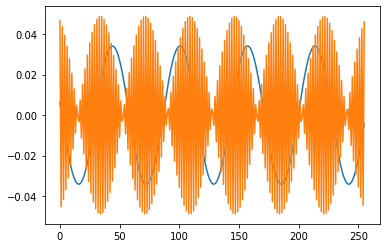

In [65]:
i = 0
A_u = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_ray_trafo_{i}.npz")
u_op = get_op(A_u,c.x_res, c.y_res, c.num_angles, c.detector_points)
A_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/v_ray_trafo_{i}.npz")
v_op = get_op(A_v,c.x_res, c.y_res, c.num_angles, c.detector_points)
A_u_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_{i}.npz")
u_v_op = get_op(A_u_v,c.x_res, c.y_res, c.num_angles, c.detector_points)
shift_params = np.load(f'Matritzen/64_64_256_96_1_u_and_v_shift/shift_params_{i}.npy')

plt.plot(get_shift(shift_params)(static_ray_trafo.geometry.angles))

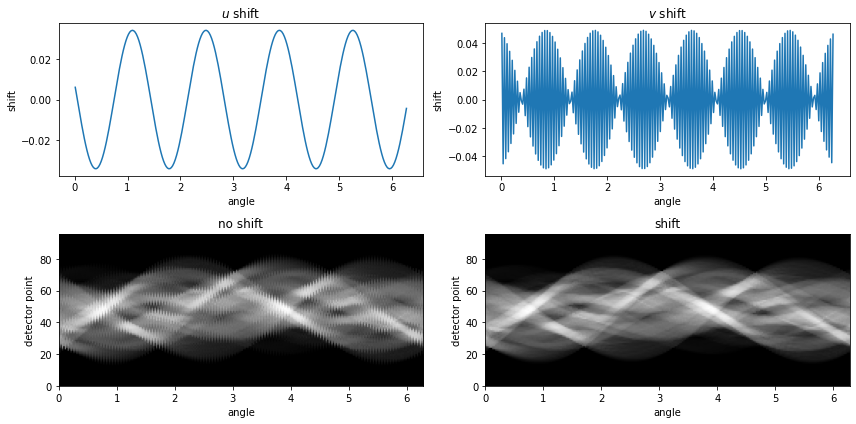

In [66]:
fig, axs = plots (2,2,4/2)
axs[0,0].set_title(r'$u$ shift')
axs[0,0].plot(static_ray_trafo.geometry.angles,get_shift(shift_params)(static_ray_trafo.geometry.angles)[:,0])
axs[0,0].set_xlabel('angle')
axs[0,0].set_ylabel('shift')
axs[0,1].set_title(r'$v$ shift')
axs[0,1].plot(static_ray_trafo.geometry.angles,get_shift(shift_params)(static_ray_trafo.geometry.angles)[:,1])
axs[0,1].set_xlabel('angle')
axs[0,1].set_ylabel('shift')
axs[1,0].imshow(u_v_op(p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs[1,0].set_title(r"no shift")
axs[1,0].set_xlabel('angle')
axs[1,0].set_ylabel('detector point')
axs[1,1].imshow(static_op(p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs[1,1].set_title(r"shift")
axs[1,1].set_xlabel('angle')
axs[1,1].set_ylabel('detector point')
fig.tight_layout()


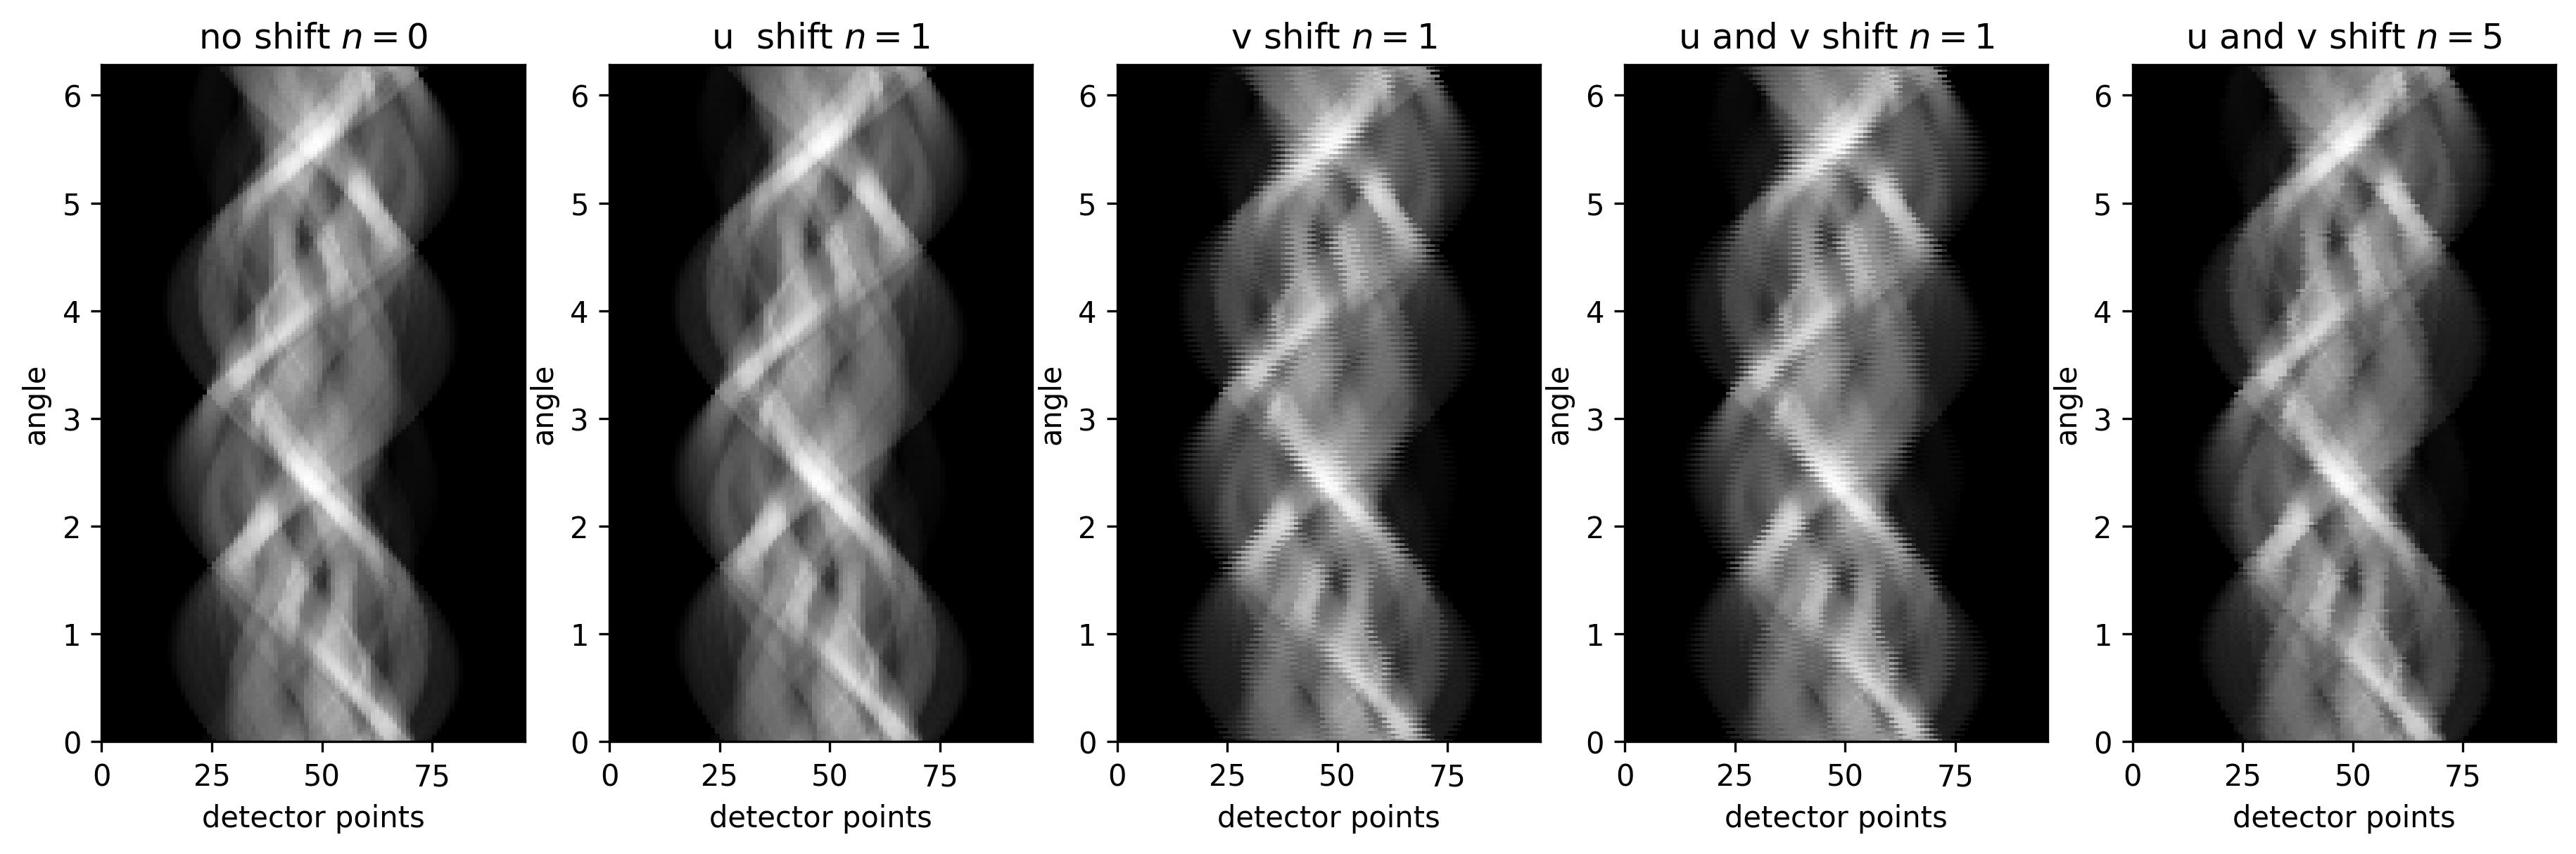

In [67]:
fig,axs = plots(1,5,3/5,5)
axs[0].imshow(static_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[0].set_title(r"no shift $n=0$")
axs[0].set_xlabel('detector points')
axs[0].set_ylabel('angle')
axs[1].imshow(u_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[1].set_title(r"u  shift $n=1$")
axs[1].set_xlabel('detector points')
axs[1].set_ylabel('angle')
axs[2].imshow(v_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[2].set_title(r" v shift $n=1$")
axs[2].set_xlabel('detector points')
axs[2].set_ylabel('angle')
axs[3].imshow(u_v_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[3].set_title(r"u and v shift $n=1$")
axs[3].set_xlabel('detector points')
axs[3].set_ylabel('angle')
axs[4].imshow(true_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[4].set_title(r"u and v shift $n=5$")
axs[4].set_xlabel('detector points')
axs[4].set_ylabel('angle')
fig.set_dpi(300)
#hide_axis(fig)

Text(0, 0.5, 'angle')

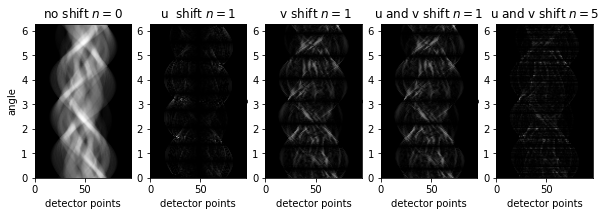

In [68]:
fig,axs = plots(1,5,16/(5*8),5)
axs[0].imshow(static_op(p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[0].set_title(r"no shift $n=0$")
axs[0].set_xlabel('detector points')
axs[0].set_ylabel('angle')
axs[1].imshow(np.abs(u_op(p)-static_op(p)),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[1].set_title(r"u  shift $n=1$")
axs[1].set_xlabel('detector points')
axs[1].set_ylabel('angle')
axs[2].imshow(np.abs(v_op(p)-static_op(p)),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[2].set_title(r" v shift $n=1$")
axs[2].set_xlabel('detector points')
axs[2].set_ylabel('angle')
axs[3].imshow(np.abs(u_v_op(p)-static_op(p)),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[3].set_title(r"u and v shift $n=1$")
axs[3].set_xlabel('detector points')
axs[3].set_ylabel('angle')
axs[4].imshow(np.abs(true_op(p)-static_op(p)),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 256/(2*np.pi)*3/5)
axs[4].set_title(r"u and v shift $n=5$")
axs[4].set_xlabel('detector points')
axs[4].set_ylabel('angle')
# fig.set_dpi(300)

Text(0, 0.5, 'detector point')

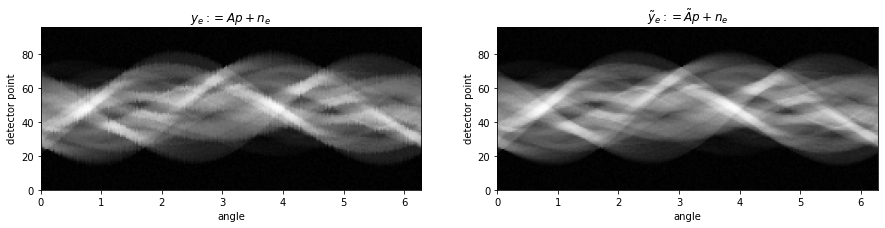

In [26]:
fig,axs = plots(1,2,5/2)
axs[0].imshow(error_for_y(true_op(p), c.e_p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs[0].set_title(r"no shift")
axs[0].set_xlabel('angle')
axs[0].set_ylabel('detector point')
axs[1].imshow(error_for_y(static_op(p), c.e_p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
axs[1].set_title(r"shift")
axs[1].set_xlabel('angle')
axs[1].set_ylabel('detector point')
# fig.set_dpi(300)

In [34]:
static_op_norm = np.linalg.norm(A_static_s.todense(),2)

In [29]:
op_norm_diff = np.linalg.norm((A_s-A_static_s).todense(),2)/static_op_norm

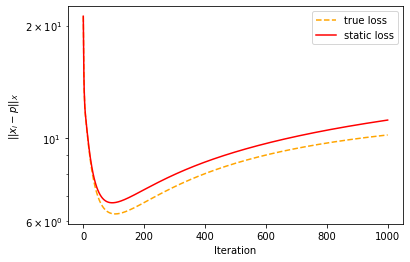

In [42]:
y = true_op(p)
c.e_p=0.3
y_e = error_for_y(y, c.e_p)

true_step = ISTA(c.mu,c.lam,y_e,true_op,true_op.adjoint).get_impl
static_step = ISTA(c.mu,c.lam,y_e,static_op,static_op.adjoint).get_impl

x_0 = static_op.adjoint(y_e)
x_0 = np.zeros((64,64))
#x_0 = p

X_true = [x_0]
X_static = [x_0]

true_loss = [im_norm(X_true[-1]-p)]
static_loss = [im_norm(X_static[-1]-p)]

num_iterations = 1000
for j in range(num_iterations):


    X_true.append(true_step(X_true[-1]))
    X_static.append(static_step(X_static[-1]))

    true_loss.append(im_norm(X_true[-1]-p))
    static_loss.append(im_norm(X_static[-1]-p))

fig,ax = plt.subplots()

ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$||x_i - p||_X$')
ax.legend()
# fig.set_dpi(300)
plt.show(fig)
true_loss = np.array(true_loss)
static_loss = np.array(static_loss)

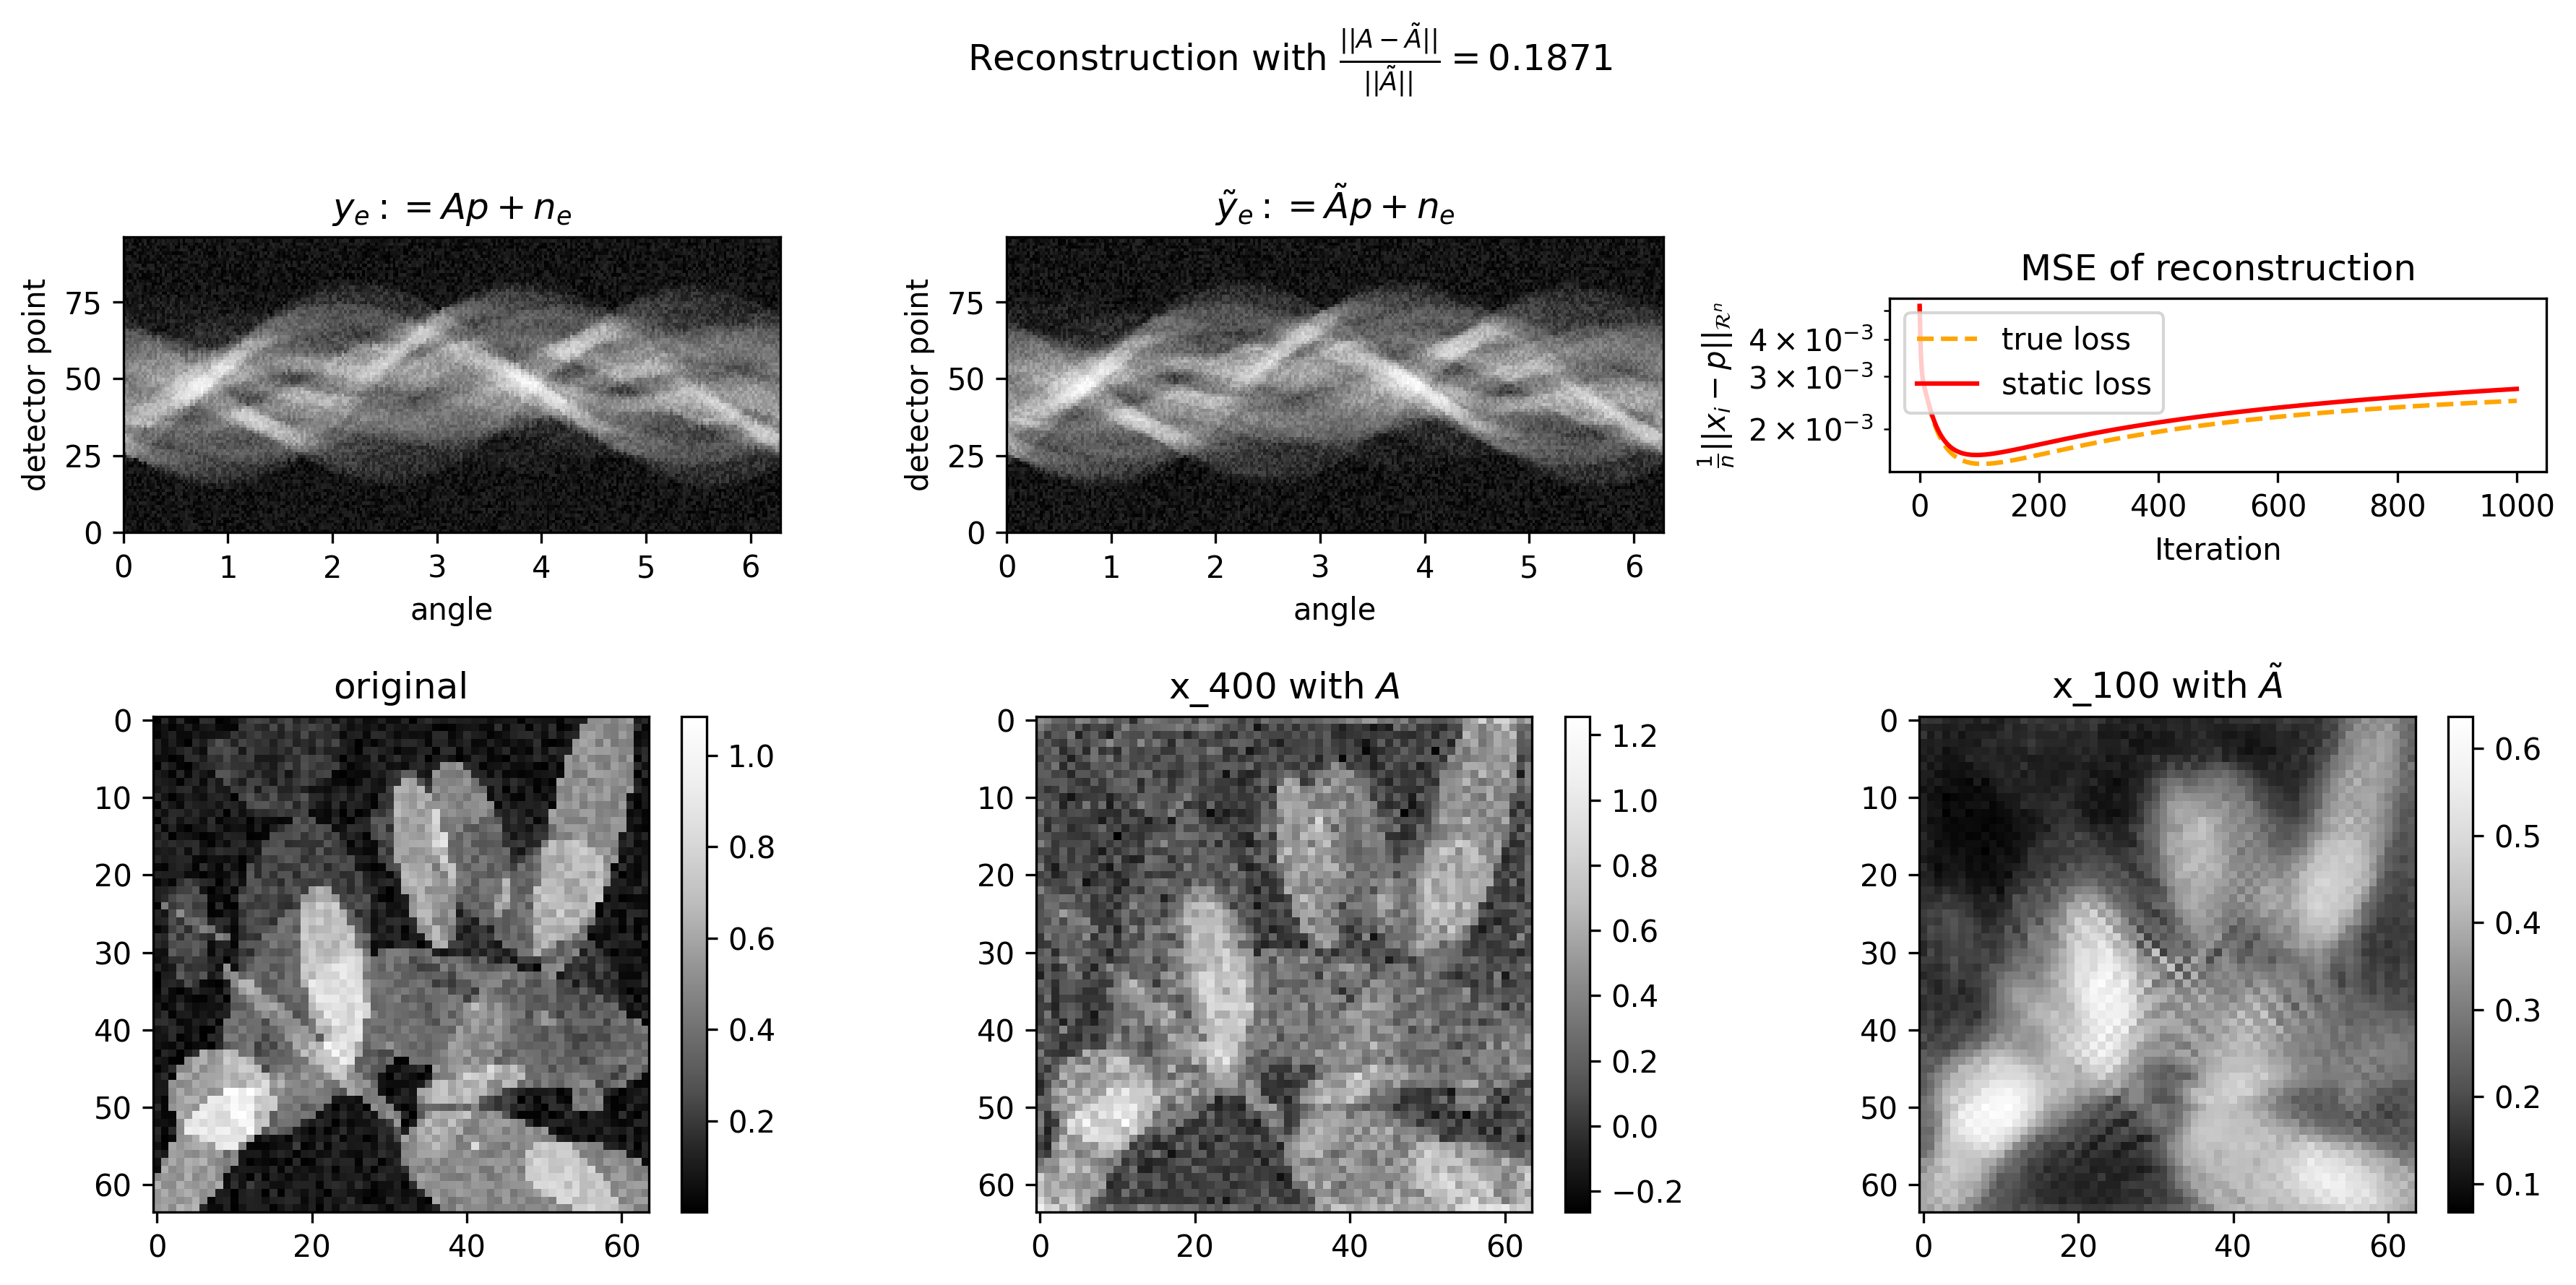

In [43]:
fig,axs = plots(2,3,4/3)
fig.suptitle(r'Reconstruction with $\frac{||A-\tilde{A}||}{||\tilde{A}||}=$'+f'{op_norm_diff:.04}')
axs[0,0].imshow(error_for_y(true_op(p), c.e_p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96])
axs[0,0].set_aspect((2*np.pi)/256*6/5)
axs[0,0].set_title(r"$y_e:=Ap+n_e$")
axs[0,0].set_xlabel('angle')
axs[0,0].set_ylabel('detector point')
axs[0,1].imshow(error_for_y(static_op(p), c.e_p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96])
axs[0,1].set_aspect((2*np.pi)/256*6/5)
axs[0,1].set_title(r"$\tilde{y}_e := \tilde{A}p+n_e$")
axs[0,1].set_xlabel('angle')
axs[0,1].set_ylabel('detector point')

axs[0,2].plot(true_loss/p.size,'orange',linestyle='--',label = 'true loss')
axs[0,2].set_aspect(500)
axs[0,2].set_title('MSE of reconstruction')
axs[0,2].plot(static_loss/p.size,'r',label = 'static loss')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel('Iteration')
axs[0,2].set_ylabel(r'$\frac{1}{n}||x_i - p||_{\mathcal{R}^n}$')
axs[0,2].legend()

axs[1,0].set_title('original')
i=400
im = axs[1,0].imshow(error_for_y(p, c.e_p),cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,0])
axs[1,1].set_title(rf'x_{i} with $A$')
im = axs[1,1].imshow(X_true[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,1])
i = 100
axs[1,2].set_title(rf'x_{i} with '+ r'$\tilde{A}$')
im = axs[1,2].imshow(X_static[20],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,2])
fig.set_dpi(300)
fig.tight_layout()

In [39]:
a = axs[0,0]
a.set_aspect(5/4)

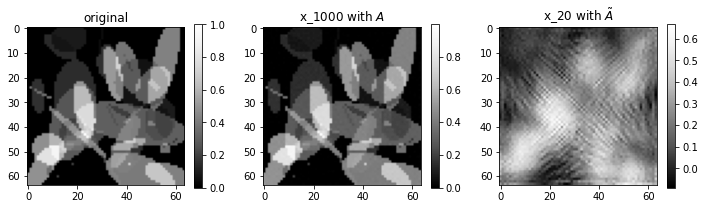

In [153]:
i = 1000
fig,axs = plots(1,3,4/3)
# fig.suptitle()
axs[0].set_title('original')
im = axs[0].imshow(p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0])
axs[1].set_title(rf'x_{i} with $A$')
im = axs[1].imshow(X_true[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1])
i = 20
axs[2].set_title(rf'x_{i} with '+ r'$\tilde{A}$')
im = axs[2].imshow(X_static[20],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[2])
# fig.set_dpi(300)
plt.show(fig)

In [185]:
# rt_norm = sparse.linalg.norm(A_static_s.T)
# rt_norm = np.sqrt(np.linalg.norm((A_static_s.T@A_static_s).todense(),2))
rt_norm = static_op_norm
np.load('presentationBilder/')

In [ ]:
presentationBilder/

ISTA training on 5 random operators 4  are loaded form a list of 100 1 is crated new with 2 added shifts on phantom space aragement


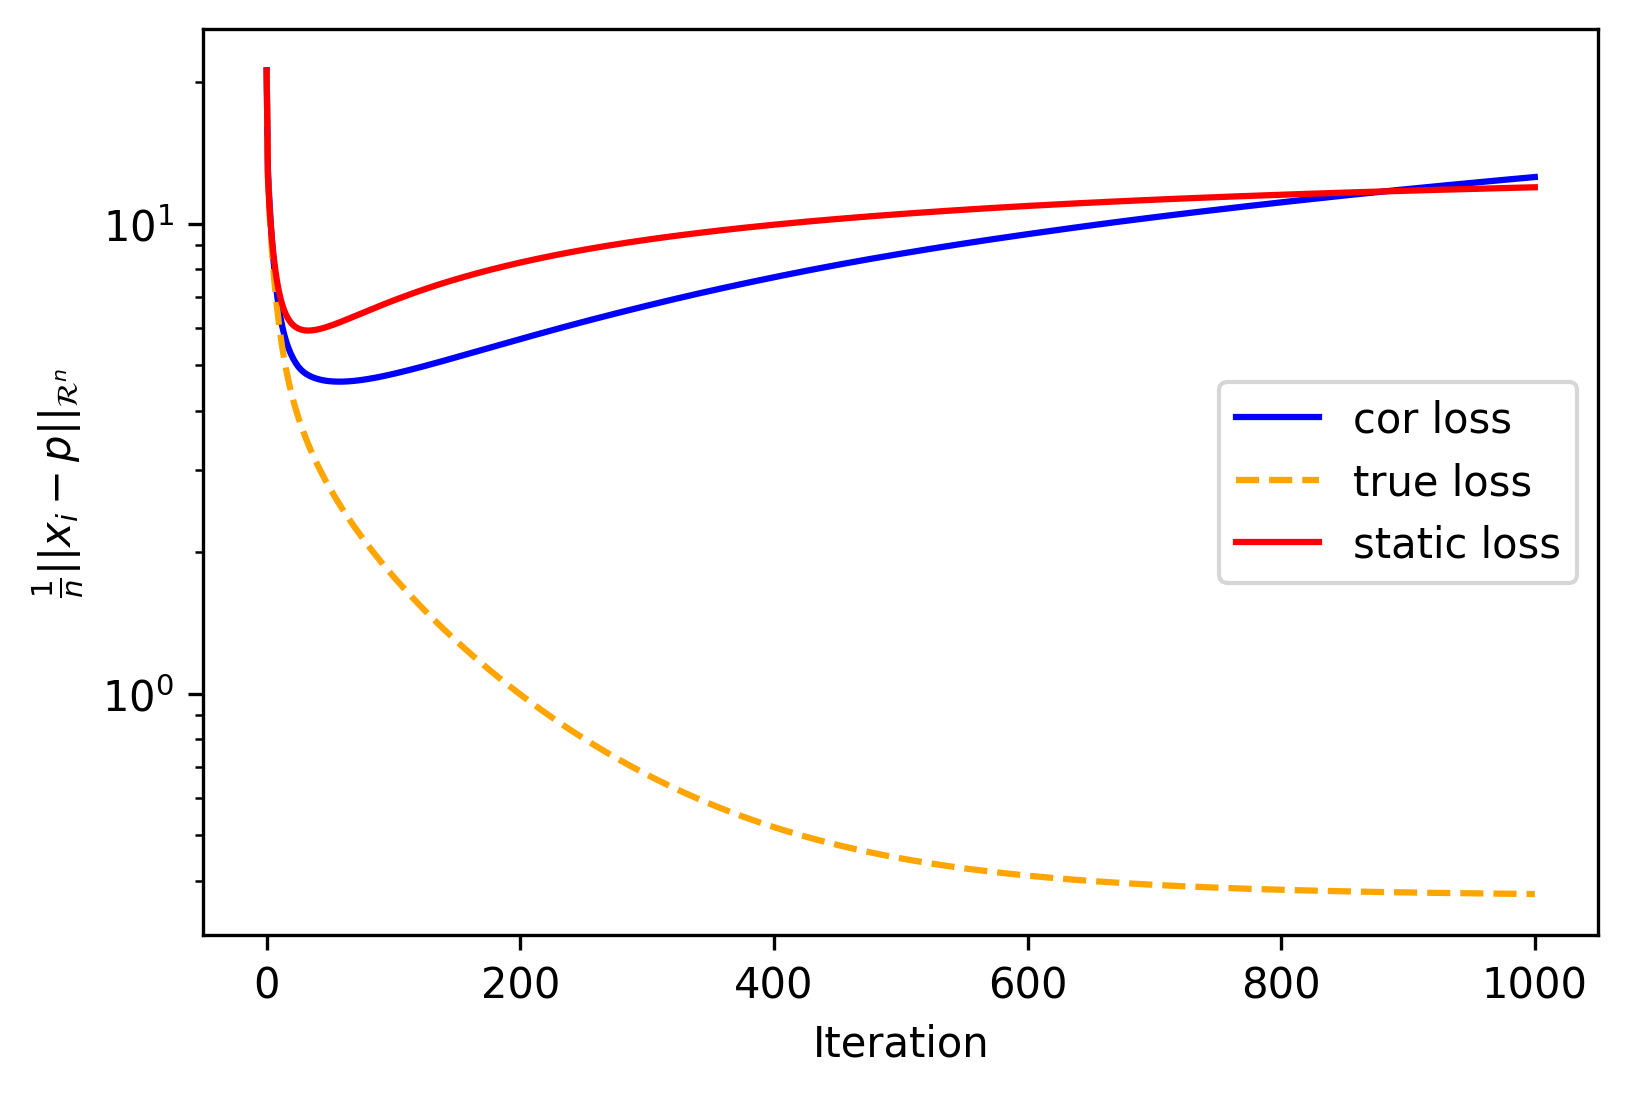

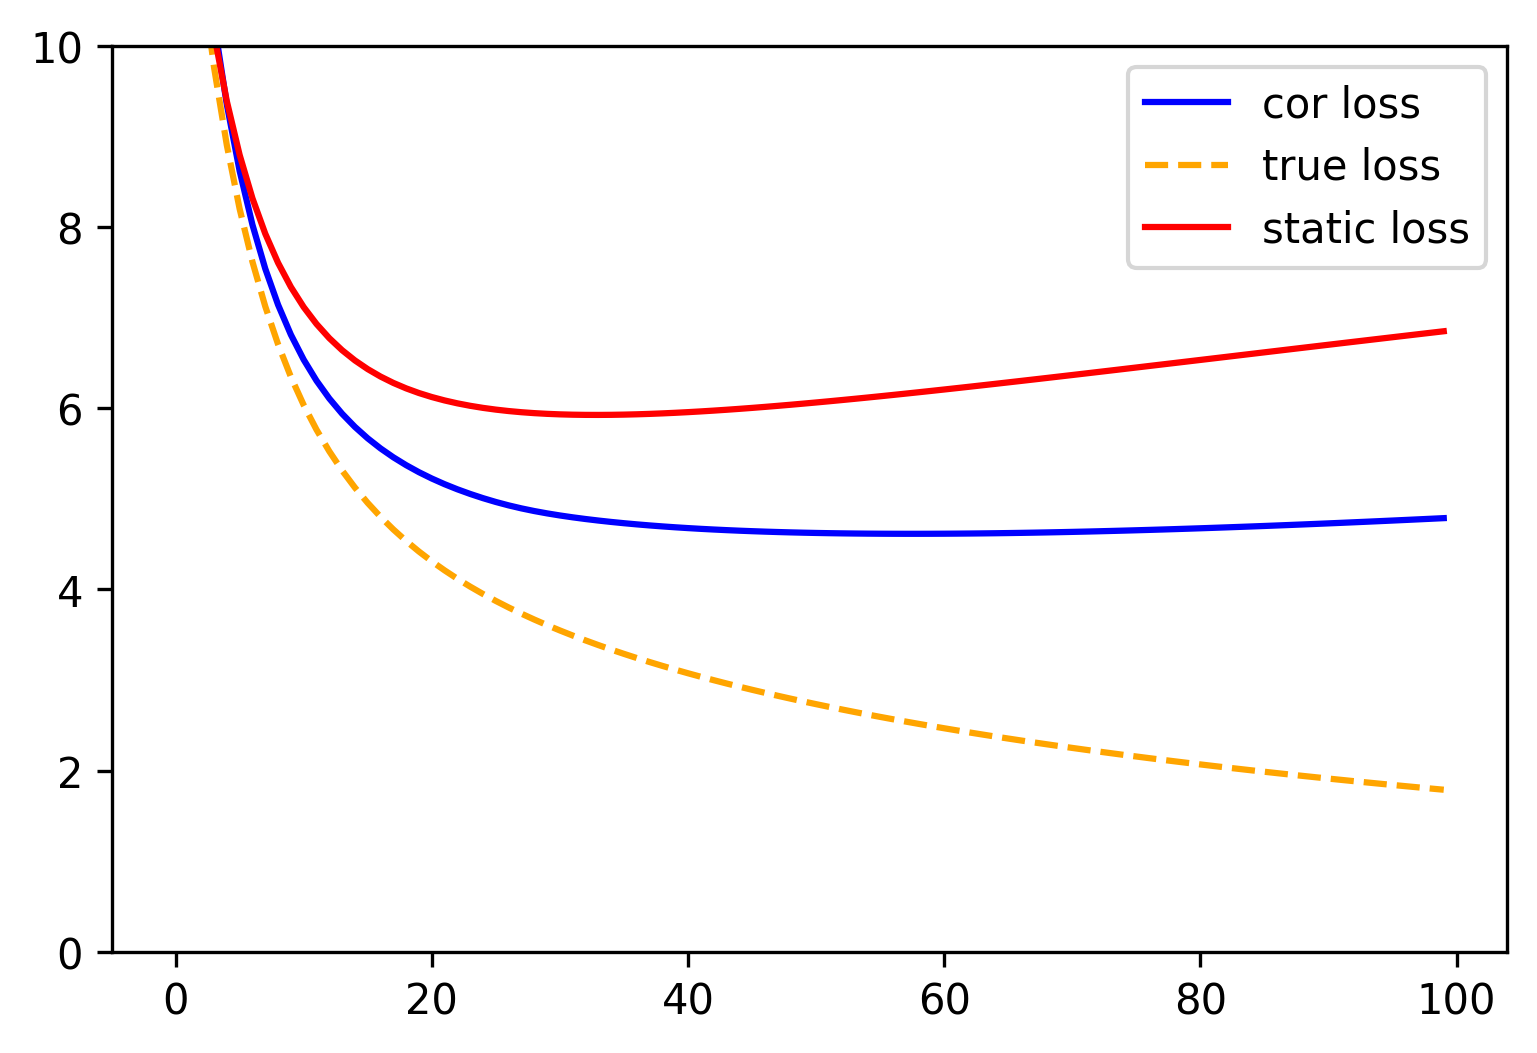

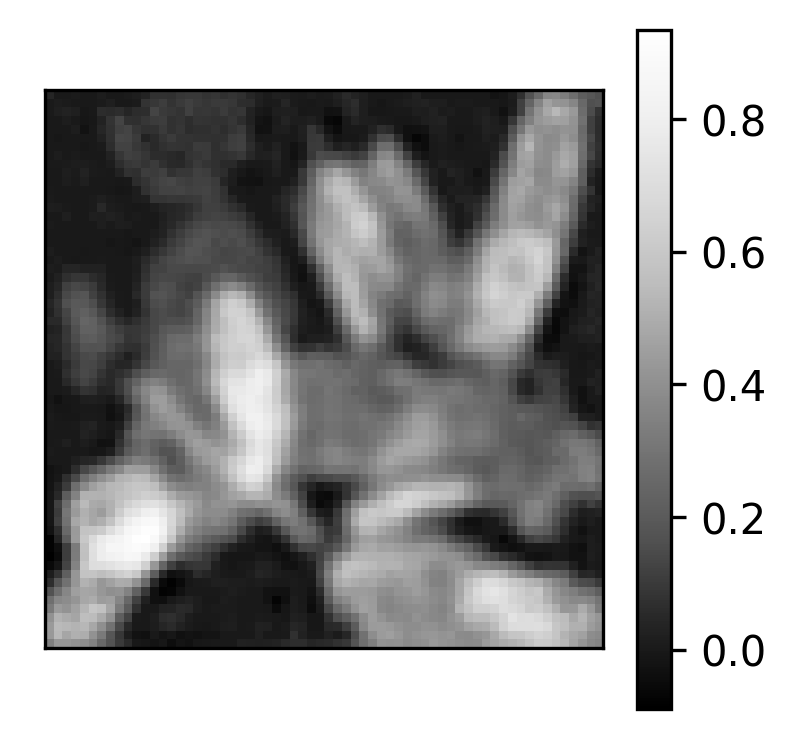

In [24]:
n = 24
path = 'presentationBilder/'
name = f'{n} x_0 strong'
fileending = '.png'
c = config(f'run_202208{n}_matrix_ISTA')
path = c.path
print(c.note)
TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
AT_static_s = sparse.csr_matrix(A_static_s.T)
TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
adjoint_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
a = '_iter_49'#'last'#'iter_46'
model.load_state_dict(torch.load(c.model_path + 'model' + a,map_location=device))
adjoint_model.load_state_dict(torch.load(c.model_path + 'adjoint_model' + a,map_location=device))
model = model.to(device)
adjoint_model = adjoint_model.to(device)
cor_op = get_net_corected_operator(static_op, model,device = device,swaped=c.forward_swaped)
cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=c.adj_swaped)

y = true_op(p)
# c.e_p=0.01
y_e = error_for_y(y, c.e_p)

step = ISTA(c.mu,c.lam,y_e,cor_op,cor_adj_op).get_impl
true_step = ISTA(c.mu,c.lam,y_e,true_op,true_op.adjoint).get_impl
static_step = ISTA(c.mu,c.lam,y_e,static_op,static_op.adjoint).get_impl

x_0 = static_op.adjoint(y_e)
x_0 = np.zeros((64,64))
#x_0 = p

X_cor = [x_0]
X_true = [x_0]
X_static = [x_0]
cor_loss = [im_norm(X_cor[-1]-p)]
true_loss = [im_norm(X_true[-1]-p)]
static_loss = [im_norm(X_static[-1]-p)]

num_iterations = 1000


for j in range(num_iterations):

    X_cor.append(step(X_cor[-1]))
    X_true.append(true_step(X_true[-1]))
    X_static.append(static_step(X_static[-1]))
    cor_loss.append(im_norm(X_cor[-1]-p))
    true_loss.append(im_norm(X_true[-1]-p))
    static_loss.append(im_norm(X_static[-1]-p))

fig,ax = plt.subplots()
ax.plot(cor_loss,'b',label = 'cor loss')
ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\frac{1}{n}||x_i - p||_{\mathcal{R}^n}$')
# ax.set_title('MSE of reconstruction')
ax.legend()
fig.set_dpi(300)
fig.savefig(path+name+'loss'+fileending)
plt.show(fig)

i = 100
fig,ax = plt.subplots()
ax.plot(cor_loss[:i],'b',label = 'cor loss')
ax.plot(true_loss[:i],'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss[:i],'r',label = 'static loss')
# ax.set_yscale('log')
ax.set_ylim([0,10])
ax.legend()
fig.set_dpi(300)
fig.savefig(path+name+'loss_100'+fileending)
plt.show(fig)

i = 50
fig,ax = plots(1,1)
im = ax.imshow(X_cor[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
fig.savefig(path+name+f'x_i{i}'+fileending)
plt.show(fig)

In [23]:
A_s = sparse.load_npz("Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_0.npz")
#A_s = sparse.load_npz('Matritzen/Test_ray_trafo_64_256_96_100.npz')
#A_s = sparse.load_npz('Matritzen/64_64_256_96_strong_u_v_shift.npz')
#A_s = sparse.load_npz("Matritzen/Test_64_256_96_5addet_u_v.npz")
true_op = get_op(A_s,c.x_res, c.y_res, c.num_angles, c.detector_points)

In [ ]:
save_path = 'presentationBilder/'
info_name = 'x_0 0 strong'
for n in range(22,26):
    
    name = f'{n}' + info_name 
    fileending = '.png'
    c = config(f'run_202208{n}_matrix_ISTA')
    c.mu = 0.0002
    path = c.path
    print(c.note)
    TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
    model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
    AT_static_s = sparse.csr_matrix(A_static_s.T)
    TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
    adjoint_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
    a = '_iter_49'#'last'#'iter_46'
    model.load_state_dict(torch.load(c.model_path + 'model' + a,map_location=device))
    adjoint_model.load_state_dict(torch.load(c.model_path + 'adjoint_model' + a,map_location=device))
    model = model.to(device)
    adjoint_model = adjoint_model.to(device)
    cor_op = get_net_corected_operator(static_op, model,device = device,swaped=c.forward_swaped)
    cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=c.adj_swaped)

    y = true_op(p)
    # c.e_p=0.01
    y_e = error_for_y(y, c.e_p)

    step = ISTA(c.mu,c.lam,y_e,cor_op,cor_adj_op).get_impl
    true_step = ISTA(c.mu,c.lam,y_e,true_op,true_op.adjoint).get_impl
    static_step = ISTA(c.mu,c.lam,y_e,static_op,static_op.adjoint).get_impl

    x_0 = static_op.adjoint(y_e)
    x_0 = np.zeros((64,64))
    #x_0 = p

    X_cor = [x_0]
    X_true = [x_0]
    X_static = [x_0]
    cor_loss = [im_norm(X_cor[-1]-p)]
    true_loss = [im_norm(X_true[-1]-p)]
    static_loss = [im_norm(X_static[-1]-p)]

    num_iterations = 1000


    for j in range(num_iterations):

        X_cor.append(step(X_cor[-1]))
        X_true.append(true_step(X_true[-1]))
        X_static.append(static_step(X_static[-1]))
        cor_loss.append(im_norm(X_cor[-1]-p))
        true_loss.append(im_norm(X_true[-1]-p))
        static_loss.append(im_norm(X_static[-1]-p))

    fig,ax = plt.subplots()
    ax.plot(cor_loss,'b',label = 'corrected op.')
    ax.plot(true_loss,'orange',linestyle='--',label = 'precise op.')
    ax.plot(static_loss,'r',label = 'static op.')
    ax.set_yscale('log')
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$\frac{1}{n}||x_i - p||_{\mathcal{R}^n}$')
    # ax.set_title('MSE of reconstruction')
    ax.legend()
    fig.set_dpi(300)
    fig.savefig(save_path+name+'loss'+fileending)
    plt.show(fig)

    i = 100
    fig,ax = plt.subplots()
    ax.plot(cor_loss[:i],'b',label = 'corrected op.')
    ax.plot(true_loss[:i],'orange',linestyle='--',label = 'precise op.')
    ax.plot(static_loss[:i],'r',label = 'static op.')
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$\frac{1}{n}||x_i - p||_{\mathcal{R}^n}$')
    # ax.set_yscale('log')
    ax.set_ylim([0,10])
    ax.legend()
    fig.set_dpi(300)
    fig.savefig(save_path+name+'loss_100'+fileending)
    plt.show(fig)

    i = 50
    fig,ax = plots(1,1,4/3)
    im = ax.imshow(X_cor[i],cmap = 'Greys_r')

    hide_axis(fig)
    fig.colorbar(im,ax=ax)
    fig.set_dpi(300)
    fig.savefig(save_path+name+f' x_{i}'+fileending)
    fig.tight_layout()
    plt.show(fig)

i = 50
fig,ax = plots(1,1,4/3)
im = ax.imshow(X_static[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
fig.savefig(save_path+info_name+f' static x_{i}'+fileending)
plt.show(fig)
i = 50
fig,ax = plots(1,1,4/3)
im = ax.imshow(X_true[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
fig.savefig(save_path+info_name+f' precise x_{i}'+fileending)
fig.tight_layout()
plt.show(fig)

fig,ax = plots(1,1,5/2)
ax.imshow(error_for_y(true_op(p), c.e_p).T,cmap='Greys_r',extent = [0,2*np.pi,0,96],aspect = 'auto')
ax.set_title(r"$y_e:=Ap+n_e$")
ax.set_xlabel('angle')
ax.set_ylabel('detector point')
fig.tight_layout()
fig.savefig(save_path+info_name+f' y_e'+fileending)
plt.show(fig)

fig,ax = plots(1,1,2/5)
ax.imshow(error_for_y(true_op(p), c.e_p),cmap='Greys_r',extent = [0,96,0,2*np.pi],aspect = 'auto')
ax.set_title(r"$y_e:=Ap+n_e$")
ax.set_xlabel('detector point')
ax.set_ylabel('angle')
fig.tight_layout()
fig.savefig(save_path+info_name+f' y_e transposed'+fileending)
plt.show(fig)



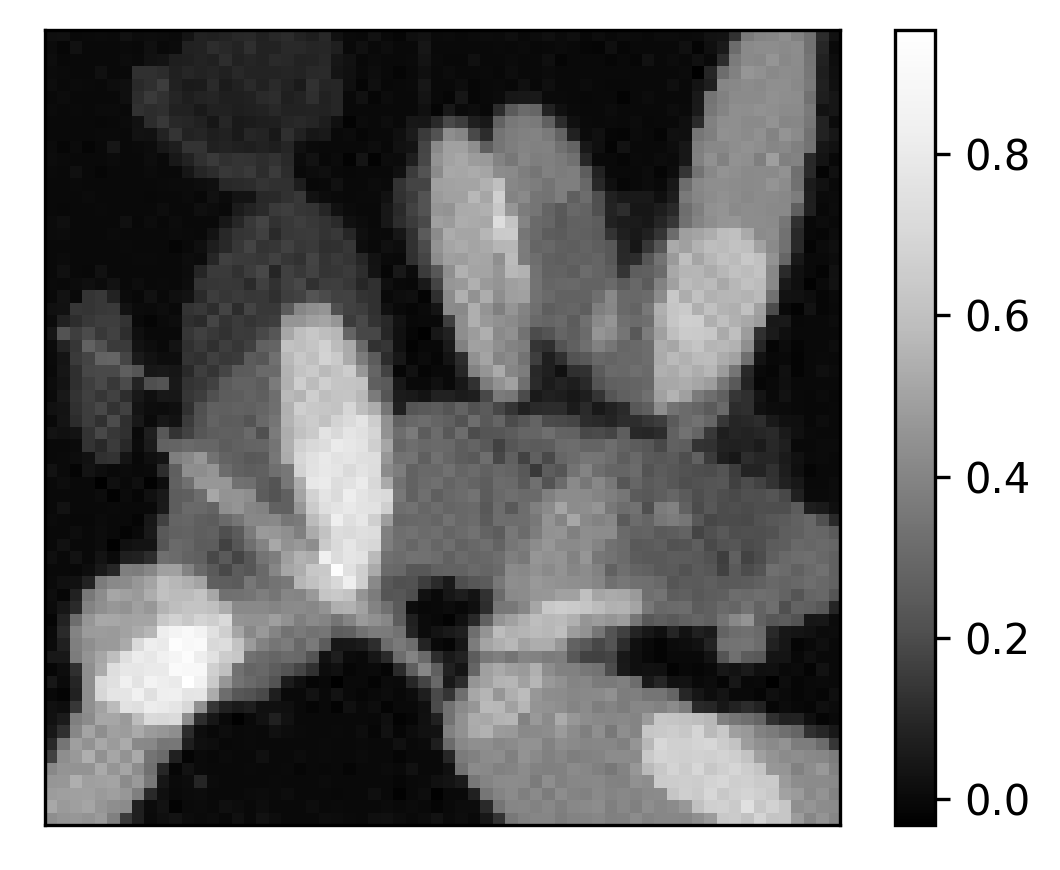

In [241]:
info_name = 'Test'
fig,ax = plots(1,1,4/3)
im = ax.imshow(X_true[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
fig.savefig(save_path+info_name+f' precise x_{i}'+fileending)
fig.tight_layout()
plt.show(fig)

In [233]:
path+name+f'x_i{i}'+fileending

'runs/run_20220825_matrix_ISTA/25 x_0 strongx_i50.png'

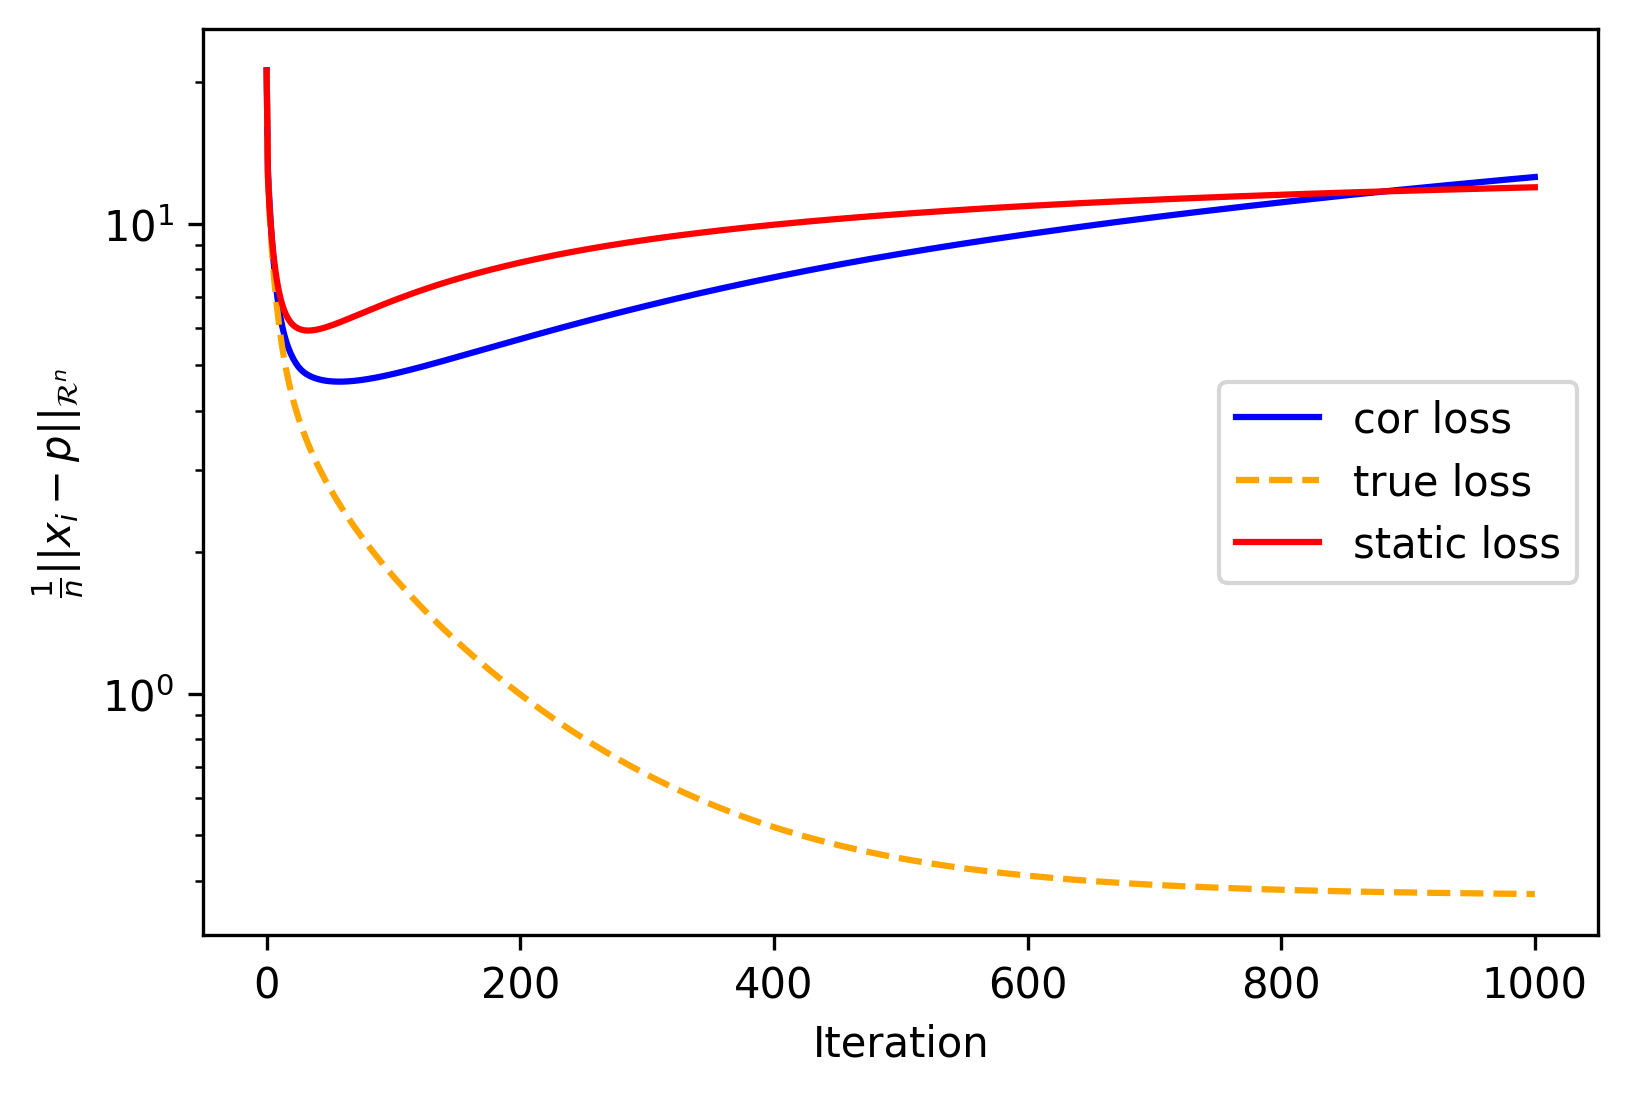

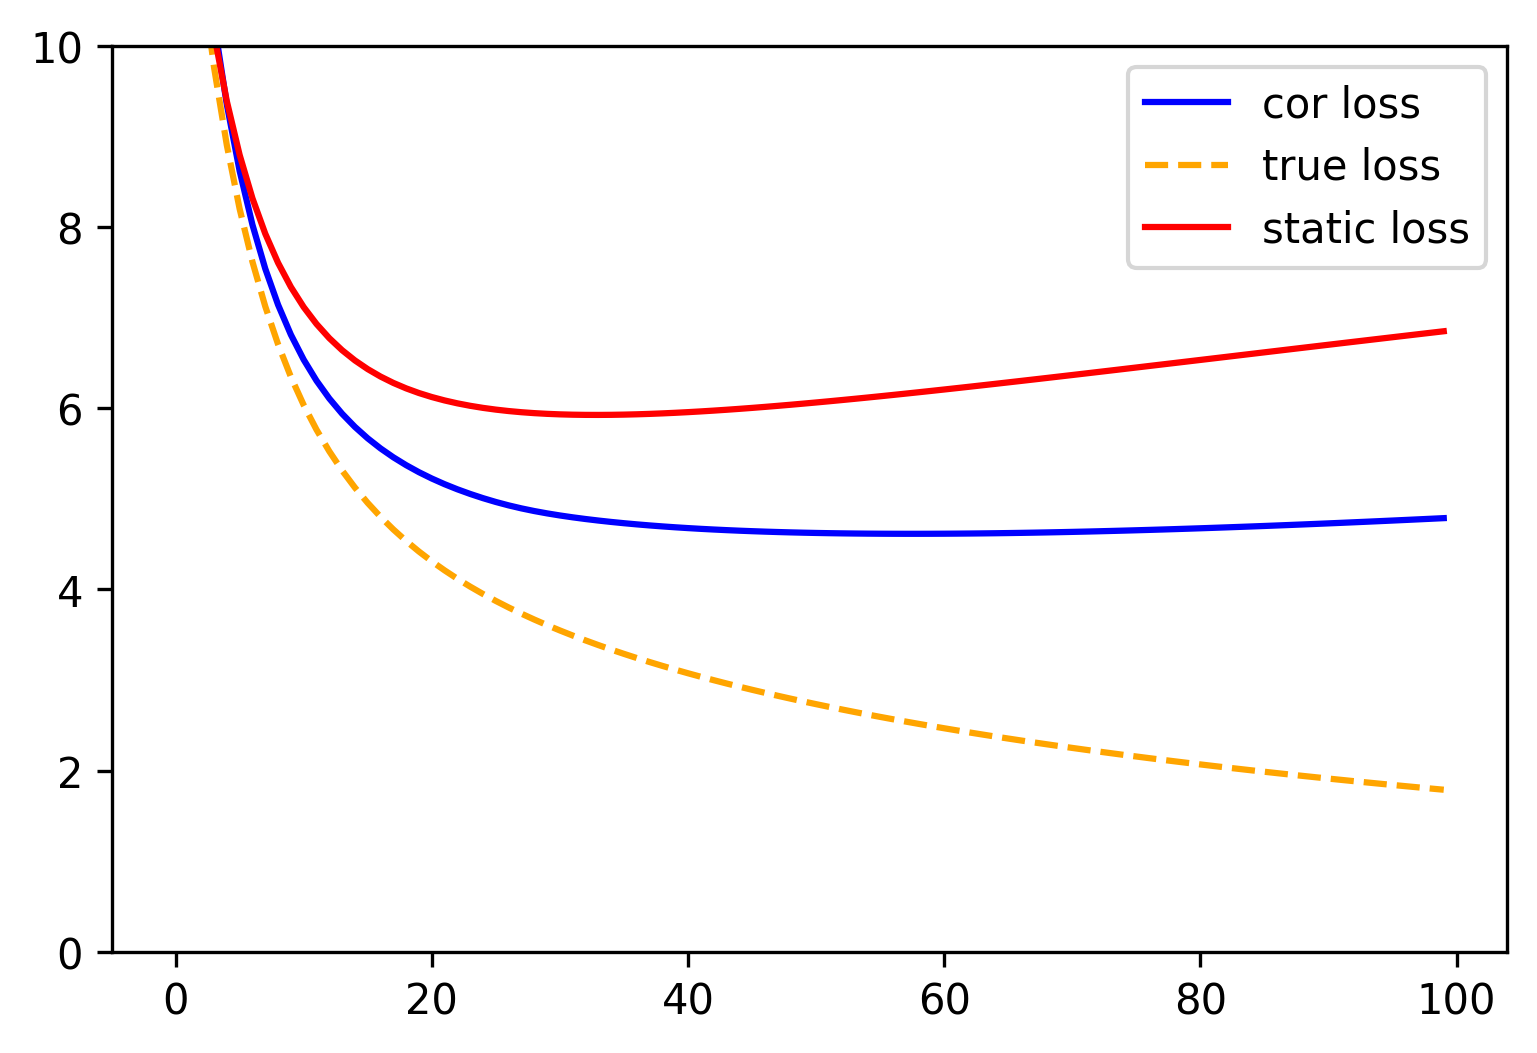

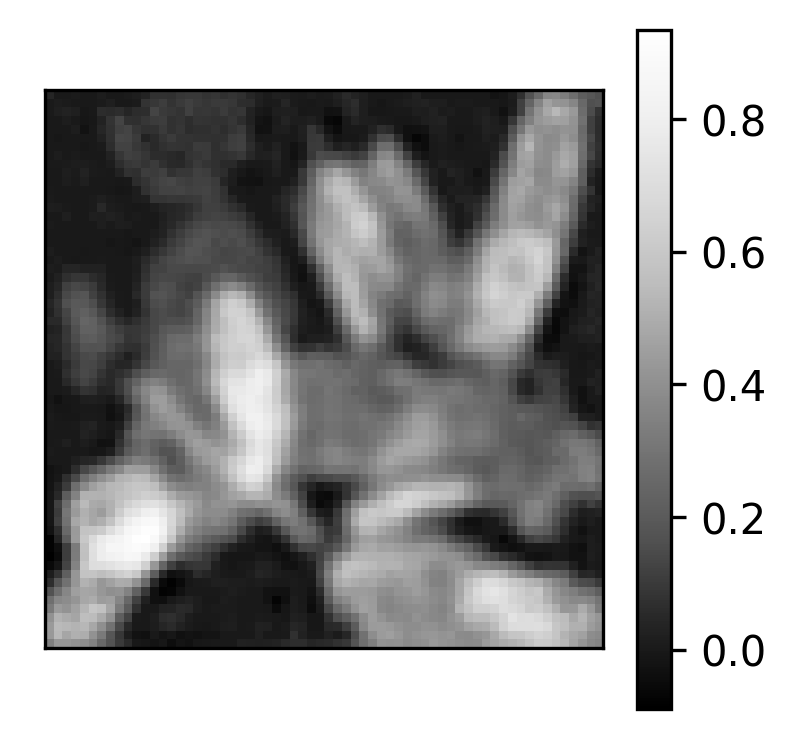

In [27]:
fig,ax = plt.subplots()
ax.plot(cor_loss,'b',label = 'cor loss')
ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\frac{1}{n}||x_i - p||_{\mathcal{R}^n}$')
# ax.set_title('MSE of reconstruction')
ax.legend()
fig.set_dpi(300)
plt.savefig(path+name+'loss'+fileending)
plt.show(fig)

i = 100
fig,ax = plt.subplots()
ax.plot(cor_loss[:i],'b',label = 'cor loss')
ax.plot(true_loss[:i],'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss[:i],'r',label = 'static loss')
# ax.set_yscale('log')
ax.set_ylim([0,10])
ax.legend()
fig.set_dpi(300)
plt.savefig(path+name+'loss_100'+fileending)
plt.show(fig)

i = 50
fig,ax = plots(1,1)
im = ax.imshow(X_cor[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
plt.savefig(path+name+f'x_i{i}'+fileending)
plt.show(fig)

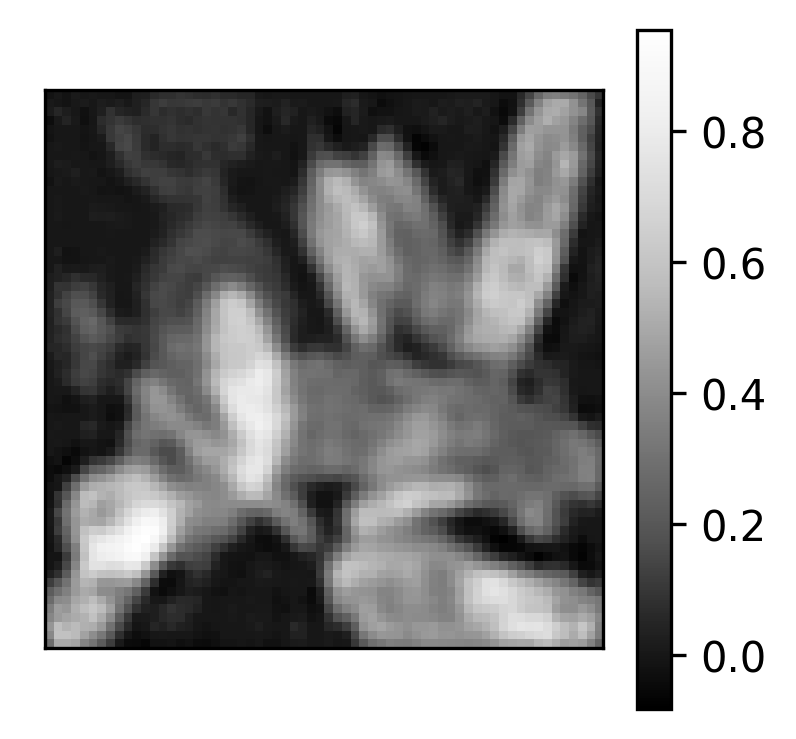

In [222]:
i = 50
fig,ax = plots(1,1)
im = ax.imshow(X_cor[i],cmap = 'Greys_r')

hide_axis(fig)
fig.colorbar(im,ax=ax)
fig.set_dpi(300)
plt.savefig(path+name+f'x_i{i}'+fileending)

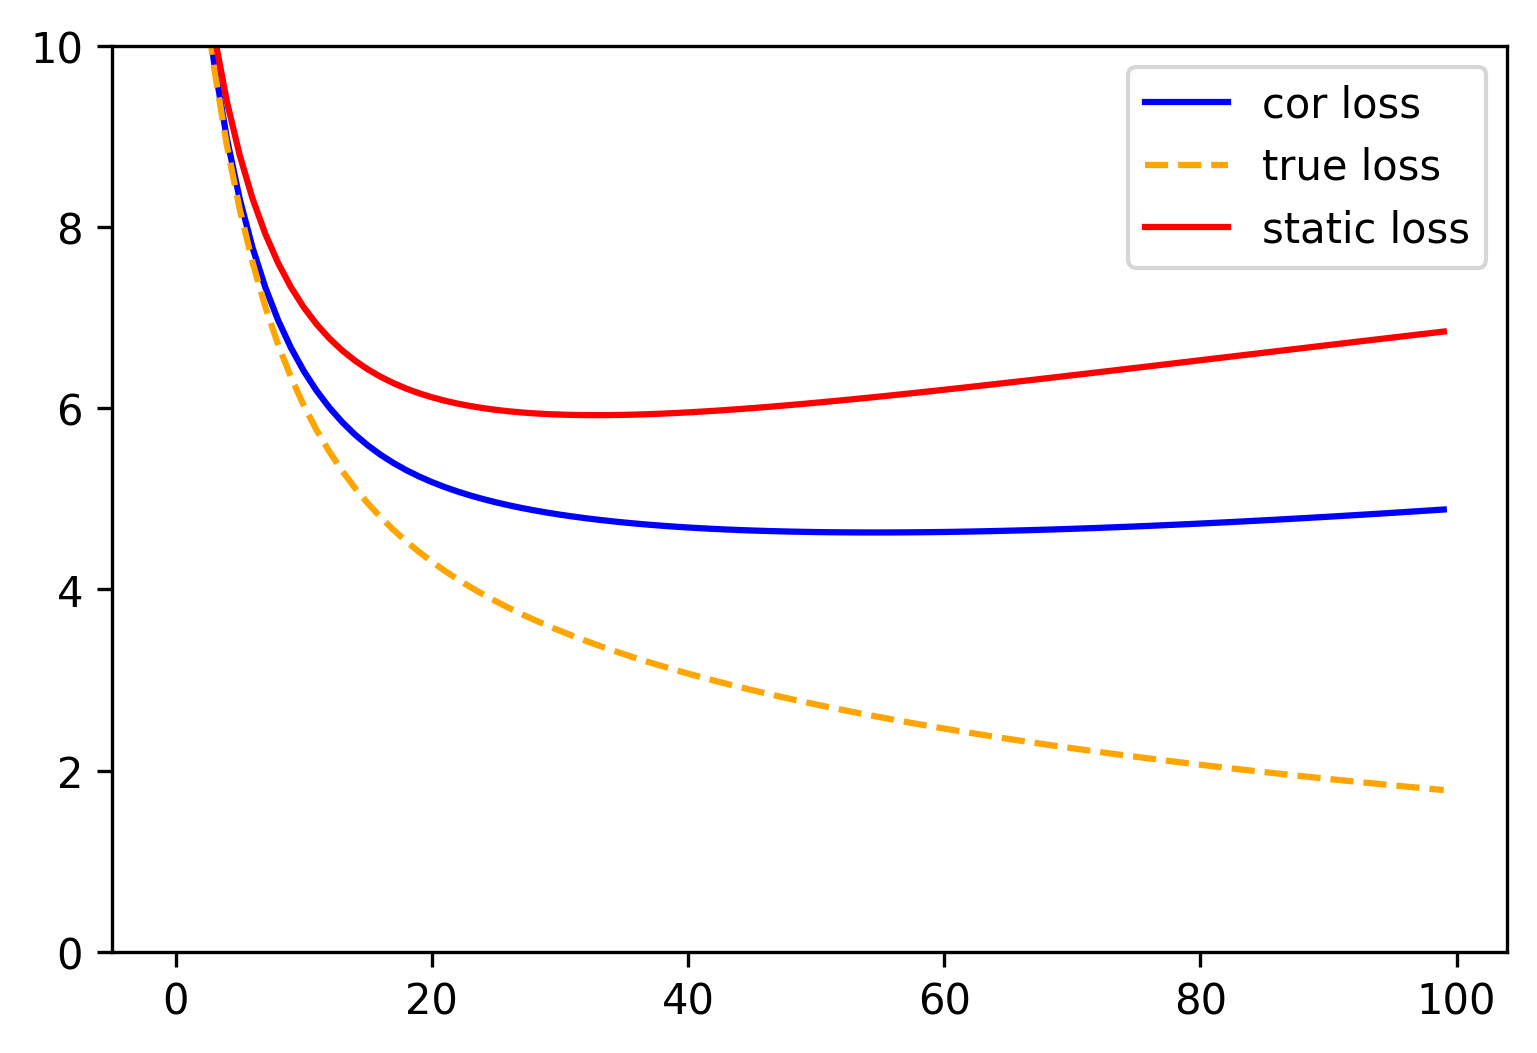

In [223]:
i = 100
fig,ax = plt.subplots()
ax.plot(cor_loss[:i],'b',label = 'cor loss')
ax.plot(true_loss[:i],'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss[:i],'r',label = 'static loss')
# ax.set_yscale('log')
ax.set_ylim([0,10])
ax.legend()
fig.set_dpi(300)
plt.savefig(path+name+'loss_100'+fileending)
plt.show(fig)

In [83]:
def norm_of_iteration_differenz(X):
    X = np.array(X)
    X = X.reshape(np.size(X,0),64**2)
    return np.linalg.norm(X[1:]-X[:-1],axis=1)


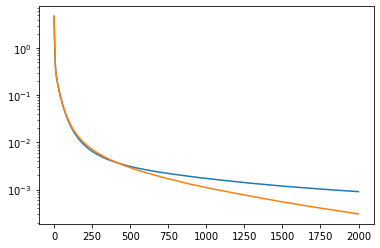

In [84]:
plt.plot(norm_of_iteration_differenz(X_static))
plt.plot(norm_of_iteration_differenz(X_true))
plt.yscale('log')

In [85]:
L = lambda x :ISTA_obj_func(true_op,y_e,c.lam,x)
def L_X(X):
    L_x = np.zeros(len(X))
    for i,x in enumerate(X):
        L_x[i] = L(x)
    return L_x

In [86]:
L_X_true = L_X(X_true)
L_X_static = L_X(X_static)

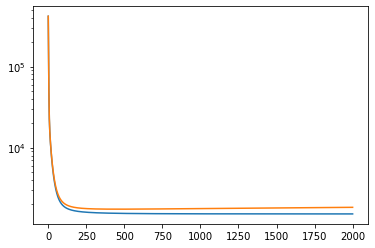

In [87]:
plt.plot(L_X_true)
plt.plot(L_X_static)
plt.yscale('log')

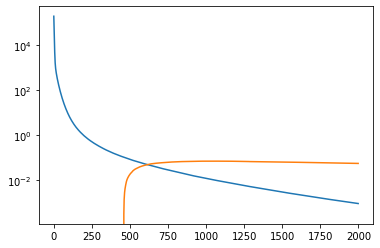

In [90]:
plt.plot(L_X_true[:-1]-L_X_true[1:])
plt.plot(-L_X_static[:-1] + L_X_static[1:] )
plt.yscale('log')

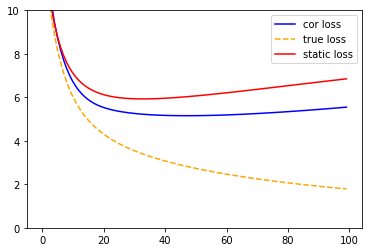

In [193]:
i = 100
fig,ax = plt.subplots()
ax.plot(cor_loss[:i],'b',label = 'cor loss')
ax.plot(true_loss[:i],'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss[:i],'r',label = 'static loss')
# ax.set_yscale('log')
ax.set_ylim([0,10])
ax.legend()
plt.show(fig)

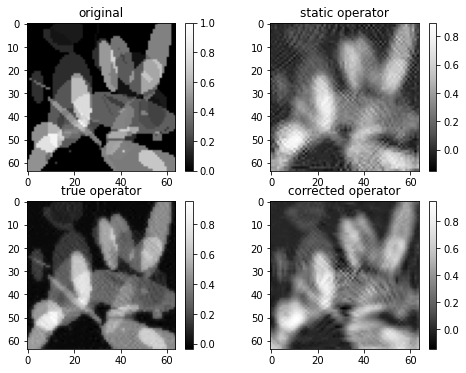

In [194]:
i = 50
fig,axs = plots(2,2,4/3)
axs[0,0].set_title('original')
im = axs[0,0].imshow(p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,0])
axs[1,0].set_title('true operator')
im = axs[1,0].imshow(X_true[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,0])
axs[0,1].set_title('static operator')
im = axs[0,1].imshow(X_static[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,1])
axs[1,1].set_title('corrected operator')
im = axs[1,1].imshow(X_cor[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,1])
plt.show(fig)

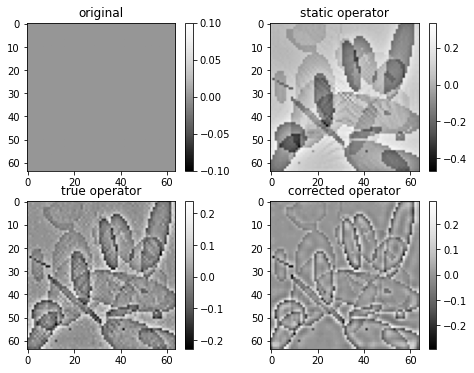

In [166]:
i = 100
fig,axs = plots(2,2,4/3)
axs[0,0].set_title('original')
im = axs[0,0].imshow(p-p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,0])
axs[1,0].set_title('true operator')
im = axs[1,0].imshow(X_true[i]-p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,0])
axs[0,1].set_title('static operator')
im = axs[0,1].imshow(X_static[25]-p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,1])
axs[1,1].set_title('corrected operator')
im = axs[1,1].imshow(X_cor[i]-p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,1])
plt.show(fig)

In [26]:
LL = np.zeros(len(X_cor)-1) #L(x)-L(x_Theta) 
AL = np.zeros(len(X_cor)-1) #Alignement
FF = np.zeros(len(X_cor)-1) #loss to derivative of precise operator
FwL = np.zeros(len(X_cor)-1) #forward Loss
AdL = np.zeros(len(X_cor)-1) #adjoint Loss
ALF = np.zeros(len(X_cor)-1) #adjoint Loss
LB = np.zeros(len(X_cor)-1) #Lowerbound
TM = np.zeros(len(X_cor)-1) #T_Thetah_mu
TM_true = np.zeros(len(X_cor)-1) #T_Thetah_mu
TT = np.zeros(len(X_cor)-1)
grad_F_Theta = np.zeros(len(X_cor)-1)
grad_F = np.zeros(len(X_cor)-1)

L = lambda lam,x :ISTA_obj_func(true_op,y_e,lam,x)


for i,x_Theta_p in enumerate(X_cor[1:]):
    x = X_cor[i]
    T_mu = (x-x_Theta_p)/c.mu
    n_T_mu = im_norm(T_mu)
    TM[i] = n_T_mu
    F_abl = true_op.adjoint(true_op(x)-y_e)/c.lam
    r = cor_op(x)-y_e
    F_Theta_abl = cor_adj_op(r)/c.lam
    LL[i] = (L(c.lam,x)-L(c.lam,x_Theta_p))
    grad_F_Theta[i] = im_norm(F_Theta_abl - T_mu)
    grad_F[i] = im_norm(F_abl - T_true)
    FF[i] = im_norm(F_abl-F_Theta_abl)
    T_true = (x-true_step(x))/c.mu
    TT[i] = im_norm(T_true - T_mu)
    TM_true[i] = im_norm(T_true)
    AL[i] = c.mu*(sp(F_abl-F_Theta_abl,T_mu)+0.5*n_T_mu**2)
    FwL[i] = im_norm(true_op(x)-cor_op(x))
    AdL[i] = im_norm(true_op.adjoint(r)-cor_adj_op(r))
    LB[i] = c.mu*n_T_mu*(0.5*n_T_mu-1/c.lam*(rt_norm*FwL[i]+AdL[i]))
plt.plot(LL/TM**2,label='LL')
plt.plot(AL/TM**2,label='AL')
plt.plot(LB/TM**2,label='LB')
plt.yscale('log')
plt.legend()

NameError: name 'T_true' is not defined

0.0001

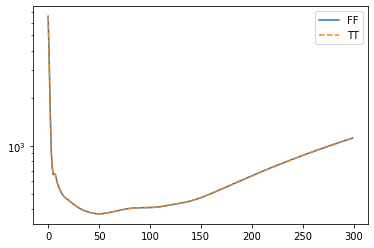

In [49]:
# plt.plot(cor_loss,label='cor_loss  ')
# plt.plot(TM,label='T_ThetaMu')
plt.plot(FF,label='FF')
# plt.plot(TM_true,label='T_Mu')
plt.plot(TT,'--',label='TT')
plt.yscale('log')
plt.legend()
c.mu

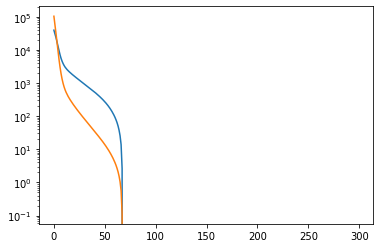

In [59]:
plt.plot(TM_true-FF)
plt.plot(AL)
plt.yscale('log')

(0.0, 10.0)

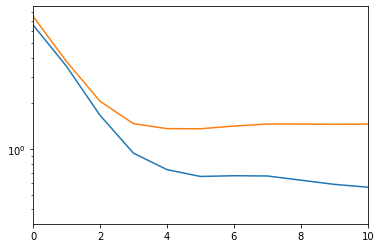

In [76]:
plt.plot(FF*c.lam)
plt.plot(rt_norm*FwL+AdL)
plt.yscale('log')
plt.xlim([0,10])

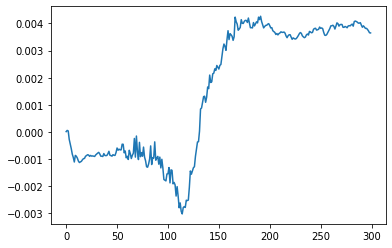

In [55]:
plt.plot((FF-TT)/FF)

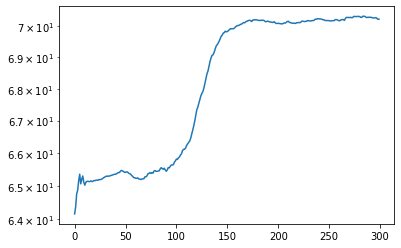

In [53]:
plt.plot(grad_F_Theta)
plt.yscale('log')

In [ ]:
plt.plot()

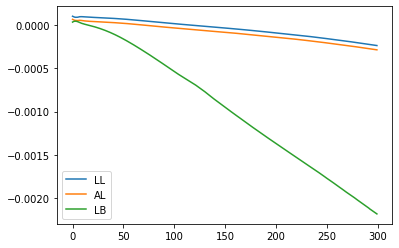

In [29]:
plt.plot(LL/TM**2,label='LL')
plt.plot(AL/TM**2,label='AL')
plt.plot(LB/TM**2,label='LB')
# plt.yscale('log')
plt.legend()

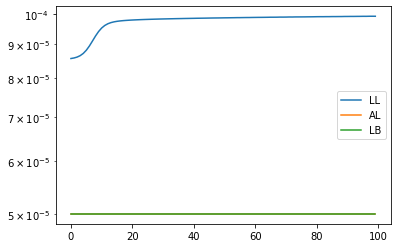

In [25]:
i = 100
plt.plot(LL[:i]/TM[:i]**2,label='LL')
plt.plot(AL[:i]/TM[:i]**2,label='AL')
plt.plot(LB[:i]/TM[:i]**2,label='LB')
plt.yscale('log')
plt.legend()

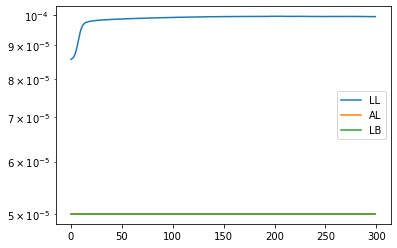

In [60]:
LL = np.zeros(len(X_cor)-1) #L(x)-L(x_Theta) 
AL = np.zeros(len(X_cor)-1) #Alignement
FwL = np.zeros(len(X_cor)-1) #forward Loss
AdL = np.zeros(len(X_cor)-1) #adjoint Loss
ALF = np.zeros(len(X_cor)-1) #adjoint Loss
LB = np.zeros(len(X_cor)-1) #Lowerbound
TM = np.zeros(len(X_cor)-1) #T_Thetah_mu


L = lambda lam,x :ISTA_obj_func(true_op,y_e,lam,x)

op = true_op
adj_op = true_op.adjoint
X = X_true
for i,x_Theta_p in enumerate(X[1:]):
    x = X[i]
    T_mu = (x-x_Theta_p)/c.mu
    n_T_mu = im_norm(T_mu)
    TM[i] = n_T_mu
    F_abl = true_op.adjoint(true_op(x)-y_e)/c.lam
    r = op(x)-y_e
    F_Theta_abl = adj_op(r)/c.lam
    LL[i] = (L(c.lam,x)-L(c.lam,x_Theta_p))
    AL[i] = c.mu*(sp(F_abl-F_Theta_abl,T_mu)+0.5*n_T_mu**2)
    FwL[i] = im_norm(true_op(x)-op(x))
    AdL[i] = im_norm(true_op.adjoint(r)-adj_op(r))
    LB[i] = c.mu*n_T_mu*(0.5*n_T_mu-1/c.lam*(rt_norm*FwL[i]+AdL[i]))
plt.plot(LL/TM**2,label='LL')
plt.plot(AL/TM**2,label='AL')
plt.plot(LB/TM**2,label='LB')
plt.yscale('log')
plt.legend()